# **Prepare**

## Import

In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def wrangle(path):
    # Read csv file into dataframe
    df = pd.read_csv(path)

    # Select the features
    df = df[[ 'YEAR', 'DATE', 'TIME', 'HOUR', 'STREET1', 'STREET2', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT',
    'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 
    'PEDCOND',  'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK','TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT',
    'ALCOHOL', 'DISABILITY', 'POLICE_DIVISION','NEIGHBOURHOOD']]


    return df    

In [3]:
path = 'data/KSI.csv'
df = wrangle(path)
print(df.shape)

(16860, 42)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   YEAR             16860 non-null  int64 
 1   DATE             16860 non-null  object
 2   TIME             16860 non-null  int64 
 3   HOUR             16860 non-null  int64 
 4   STREET1          16860 non-null  object
 5   STREET2          16860 non-null  object
 6   ROAD_CLASS       16860 non-null  object
 7   DISTRICT         16860 non-null  object
 8   LOCCOORD         16860 non-null  object
 9   ACCLOC           16860 non-null  object
 10  TRAFFCTL         16860 non-null  object
 11  VISIBILITY       16860 non-null  object
 12  LIGHT            16860 non-null  object
 13  RDSFCOND         16860 non-null  object
 14  ACCLASS          16860 non-null  object
 15  IMPACTYPE        16860 non-null  object
 16  INVTYPE          16860 non-null  object
 17  INVAGE           16860 non-null

In [5]:
df.describe()

,YEAR,TIME,HOUR
count,16860.000000,16860.000000,16860.000000
mean,2012.256168,1352.106821,13.241103
std,4.252797,629.726747,6.302679
min,2006.000000,0.000000,0.000000
25%,2009.000000,913.000000,9.000000
50%,2012.000000,1442.000000,14.000000
75%,2016.000000,1845.000000,18.000000
max,2020.000000,2359.000000,23.000000


In [8]:
df.head().transpose()

,0,1,2,3,4
YEAR,2006,2006,2006,2006,2006
DATE,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/11 05:00:00+00,2006/03/12 05:00:00+00
TIME,852,852,915,915,240
HOUR,8,8,9,9,2
STREET1,BLOOR ST W,BLOOR ST W,MORNINGSIDE AVE,MORNINGSIDE AVE,EGLINTON AVE E
STREET2,DUNDAS ST W,DUNDAS ST W,SHEPPARD AVE E,SHEPPARD AVE E,COMMONWEALTH AVE
ROAD_CLASS,Major Arterial,Major Arterial,Major Arterial,Major Arterial,Major Arterial
DISTRICT,Toronto and East York,Toronto and East York,Scarborough,Scarborough,Scarborough
LOCCOORD,Intersection,Intersection,Intersection,Intersection,Mid-Block
ACCLOC,At Intersection,At Intersection,At Intersection,At Intersection,No


## Explore

### Descriptive Analysis ( Exploratory Data Analysis)


#### Uni-variate Analysis (Comparing 1 variable at a time)

In [14]:
def conut_feature(df, xlabel, title):
    ax = sns.countplot(x=df)

    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14)
    plt.yticks(size=12)
    plt.ylabel('Number of Traffic Collisions', size=12)
    plt.title(title, size=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.tight_layout()
    plt.show()

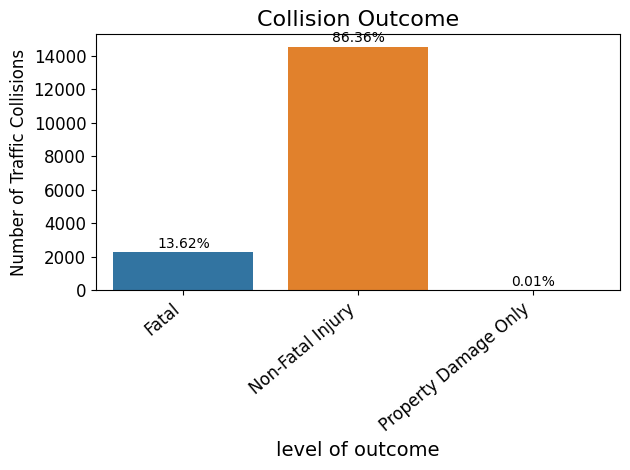

In [17]:
# What is the percentage of OUTCOME?
conut_feature(df['ACCLASS'], 'level of outcome', 'Perc12qCollision Outcome')

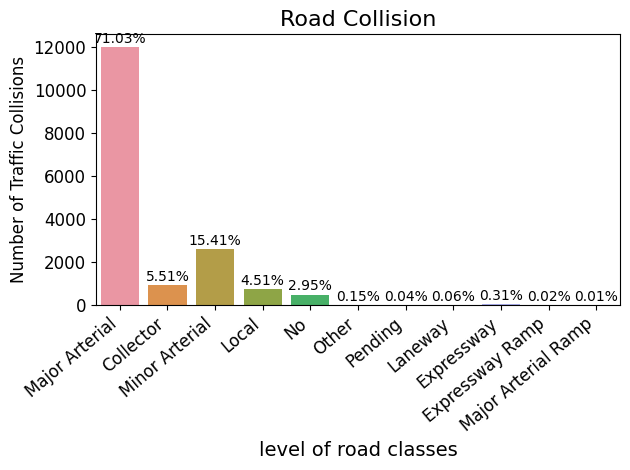

In [18]:

conut_feature(df['ROAD_CLASS'], 'level of road classes','Road Collision')


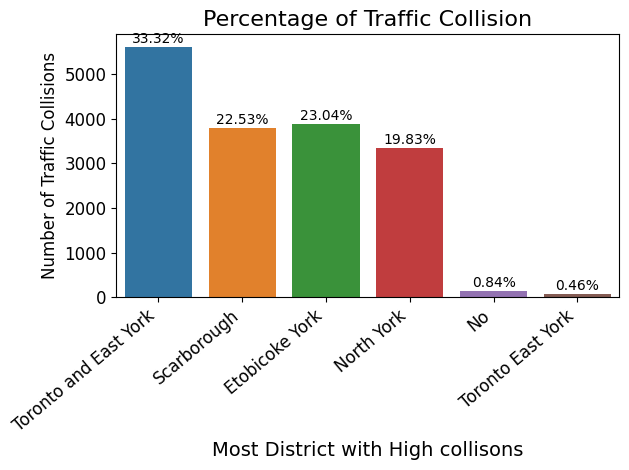

In [12]:
conut_feature(df['DISTRICT'], 'Most District with High collisons',)

<AxesSubplot:xlabel='DISTRICT', ylabel='count'>

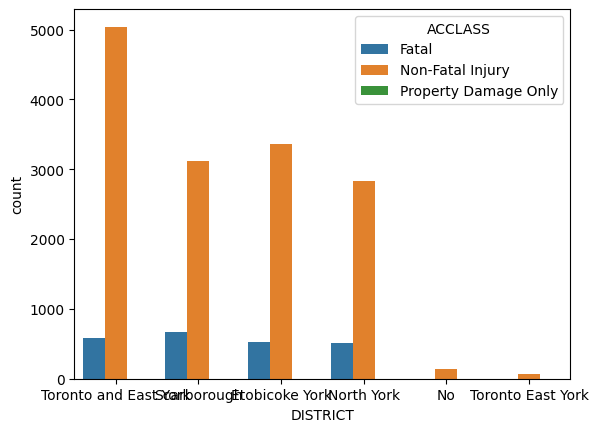

In [21]:
sns.countplot(x=df['DISTRICT'], hue=df['ACCLASS'])

<AxesSubplot:>

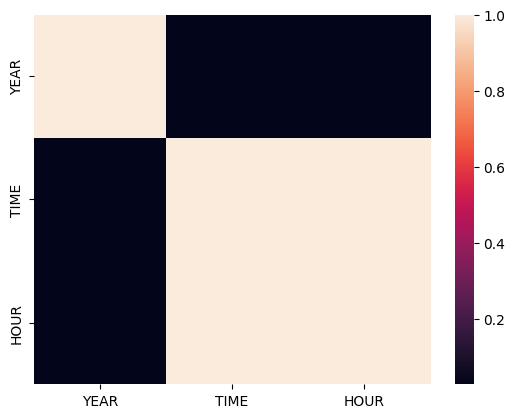

In [20]:
sns.heatmap(df.corr())

#### Remove low and high cardinality 

In [27]:
# low and high cardinality
low_high = [ 'YEAR', 'DATE', 'TIME', 'STREET1', 'STREET2', 'NEIGHBOURHOOD']

df = df.drop(low_high, axis=1)


#### Encoding

In [32]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes('object').columns:

    df[col] = le.fit_transform(df[col])

## Split

In [36]:
target = 'ACCLASS'
X = df.drop(target, axis=1)
y = df[target]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **Build Model**

## Model 1 - Logistic Regression

In [40]:
model_1 = make_pipeline(
    SimpleImputer(),
    LogisticRegression()
)
model_1.fit(X_train, y_train)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression())])

In [54]:
model_1_pred = model_1.predict(X_test)
model_1_acc = accuracy_score(y_test, model_1_pred)
print(f'Model Accuracy: {model_1_acc}')
print(classification_report(y_test, model_1_pred))

Model Accuracy: 0.8606168446026097
              precision    recall  f1-score   support

           0       0.60      0.03      0.06       713
           1       0.86      1.00      0.92      4345

    accuracy                           0.86      5058
   macro avg       0.73      0.51      0.49      5058
weighted avg       0.83      0.86      0.80      5058



## Model 2 - Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
model_2 = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier()
)
model_2.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [55]:
model_2_pred = model_2.predict(X_test)
model_2_acc = accuracy_score(y_test, model_2_pred)
print(f'Model Accuracy: {model_2_acc}')
print(classification_report(y_test, model_2_pred))

Model Accuracy: 0.9264531435349941
              precision    recall  f1-score   support

           0       0.97      0.49      0.65       713
           1       0.92      1.00      0.96      4345

    accuracy                           0.93      5058
   macro avg       0.95      0.74      0.81      5058
weighted avg       0.93      0.93      0.92      5058



## Model 3 - Suppor Vector Classifier

In [49]:
from sklearn.svm import SVC
model_3 = make_pipeline(
    SimpleImputer(),
    SVC()
)
model_3.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('svc', SVC())])

In [56]:
model_3_pred = model_3.predict(X_test)
model_3_acc = accuracy_score(y_test, model_3_pred)
print(f'Model Accuracy: {model_3_acc}')
print(classification_report(y_test, model_3_pred))

Model Accuracy: 0.8590351917754053
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       713
           1       0.86      1.00      0.92      4345

    accuracy                           0.86      5058
   macro avg       0.43      0.50      0.46      5058
weighted avg       0.74      0.86      0.79      5058



C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: Undefin

## Evaluate

In [57]:
names = ['LogisticRegression', 'RandomForestClassifier', 'Support Vector Classifier']
acc_score = [model_1_acc, model_2_acc, model_3_acc]
models = pd.DataFrame()
models['Models'] = names
models['Accuracy'] = acc_score

In [58]:
models.head()

,Models,Accuracy
0,LogisticRegression,0.860617
1,RandomForestClassifier,0.926453
2,Support Vector Classifier,0.859035


<AxesSubplot:xlabel='Models', ylabel='Accuracy'>

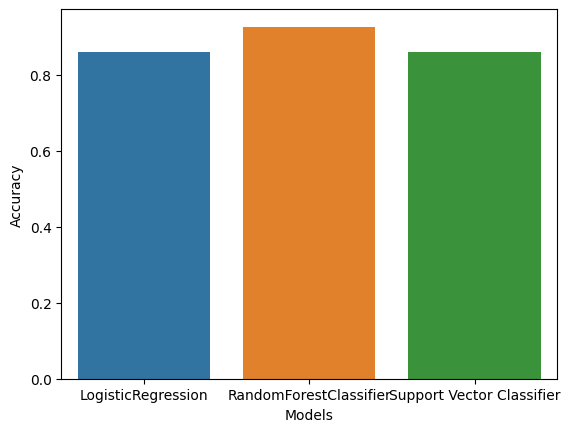

In [59]:
sns.barplot(x='Models', y='Accuracy', data=models)